# Exploratory Data Analysis with Quandl Futures Data

###  1. Importing Quandl Futures Data and Visualising Market Structure

In [1]:
import quandl
quandl.read_key()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# Import a csv of all futures contracts on Quandl Wiki Continuous Futures Database
all_available_contracts = pd.read_csv("continuous.csv")

all_available_contracts.head()

,Ticker,Exchange,Name,Months,Number of Contracts,Quandl Code
0,0D,CME,Mini European 3.5% Fuel Oil Barges FOB Rdam (P...,FGHJKMNQUVXZ,5,CHRIS/CME_0D
1,0F,CME,Mini Singapore Fuel Oil 180 cst (Platts),HJKMNQUVXZ,2,CHRIS/CME_0F
2,1MF,SGX,Platts Singapore Fuel Oil 180cst Index,FGHJKMNQUVXZ,3,CHRIS/SGX_1MF
3,1N,CME,Singapore Mogas 92 Unleaded (Platts),FGHJKMNQUVXZ,4,CHRIS/CME_1N
4,1NB,CME,Singapore Mogas 92 Unleaded (Platts) Brent Cra...,HJKMNQU,4,CHRIS/CME_1NB


In [4]:
# Filter and return the ICE Brent Contract and its corresponding attributes
ice_brent = all_available_contracts[
    (all_available_contracts['Exchange'] == 'ICE') &
    (all_available_contracts['Name'].str.contains('Brent Crude'))
]

ice_brent

,Ticker,Exchange,Name,Months,Number of Contracts,Quandl Code
53,B,ICE,Brent Crude Oil,FGHJKMNQUVXZ,25,CHRIS/ICE_B


In [5]:
# Query settlement prices for continuous Brent Crude Oil contracts from M to M+24

brent_datasets = {}

for depth in range(1, int(ice_brent['Number of Contracts']) + 1):
    brent_datasets[f"brent_{depth}"] = quandl.get(f'CHRIS/ICE_B{depth}')['Settle']

In [6]:
todays_contract_prices = []

# Return the latest prices for each Brent contract from M to M+24
for depth in range(1, int(ice_brent['Number of Contracts']) + 1):
    contract_last_px = brent_datasets[f'brent_{depth}'][-1]
    todays_contract_prices.append(contract_last_px)
    
todays_contract_prices[:5]

[69.88, 69.07, 68.42, 67.89, 67.48]

In [7]:
# Store the prices in a pandas DataFrame object
mkt_structure = pd.DataFrame()
mkt_structure['Brent Futures Price'] = pd.Series(todays_contract_prices)
mkt_structure[:5]

,Brent Futures Price
0,69.88
1,69.07
2,68.42
3,67.89
4,67.48


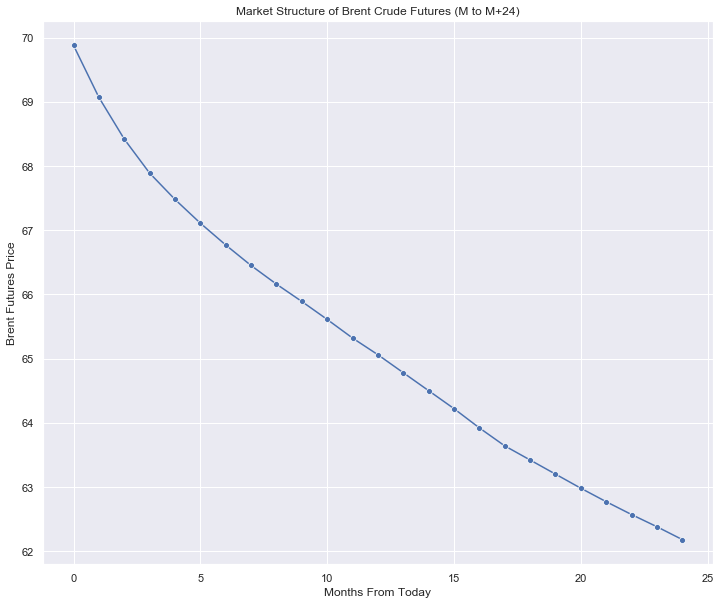

In [8]:
# Plot the price of each traded contract and visualise the market structure for Brent Crude Oil
sns.set()
sns.set_style('darkgrid')
fig = plt.figure(figsize=(12, 10))
ax = sns.lineplot(x=mkt_structure.index, y="Brent Futures Price", marker='o', data=mkt_structure)
plt.title('Market Structure of Brent Crude Futures (M to M+24)')
plt.xlabel('Months From Today');

### Analysis

The Brent Crude Market appears to be in [backwardation](https://www.investopedia.com/terms/b/backwardation.asp). This is highlighted by the fact of spot prices (roughly $\$ $71) being higher than Brent for delivery in M months time (E.g. $65.76 in 12 months time).

The backwardated market is potentially motivated by a shortage of crude in the immediate months (hence the premium for Brent today versus Brent tomorrow). This hypothesis is supported by recent news of the [US ending waivers for sanctions on Iranian Oil](https://www.ft.com/content/52f6df92-6571-11e9-9adc-98bf1d35a056). Seasonally, there is also an expectation of higher oil prices in the short-term owing to higher gasoline (and hence higher crude) demand in the summer driving months.

One potential way to play this market would be to enter into a long futures position in a contract with a later date for delivery (E.g. M+12), with the expectation of [futures prices eventually converging to spot prices](https://www.investopedia.com/ask/answers/081414/what-best-way-play-backwardation-futures-market.asp).

### 2. Time Spreads

In [9]:
# Append the time series of Brent contracts from M to M+12 to a pandas DataFrame
brent_12_months = pd.DataFrame()

for depth in range(1, 14):
    contract_data = brent_datasets[f'brent_{depth}'].copy()
    contract_data.rename(columns={'Settle': f'M+{depth-1}'}, inplace=True)
    brent_12_months[f'M+{depth-1}'] = contract_data

In [10]:
brent_12_months.tail()

,M+0,M+1,M+2,M+3,M+4,M+5,M+6,M+7,M+8,M+9,M+10,M+11,M+12
Date,,,,,,,,,,,,,
2019-05-01,72.18,71.50,70.95,70.44,70.03,69.62,69.25,68.91,68.59,68.28,67.96,67.63,67.33
2019-05-02,70.75,70.02,69.43,68.91,68.48,68.07,67.70,67.36,67.06,66.77,66.47,66.16,65.87
2019-05-03,70.85,70.03,69.37,68.82,68.39,67.98,67.61,67.27,66.96,66.67,66.36,66.04,65.76
2019-05-06,71.24,70.37,69.68,69.12,68.68,68.27,67.91,67.58,67.27,66.99,66.69,66.38,66.11
2019-05-07,69.88,69.07,68.42,67.89,67.48,67.11,66.77,66.45,66.16,65.89,65.61,65.32,65.06


In [11]:
brent_12_months.dropna(inplace=True)

c:\users\nicholas\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


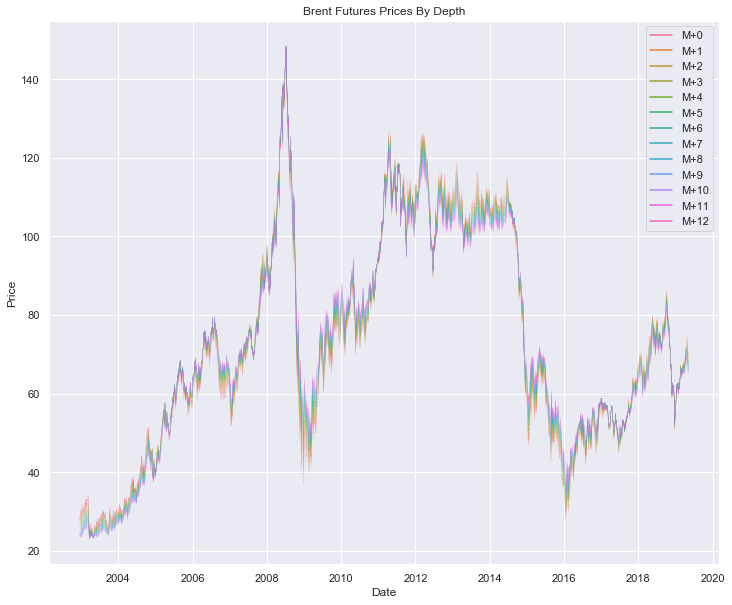

In [12]:
# Plot the price action of all 13 contracts on a graph
fig = plt.figure(figsize=(12, 10))

ax = sns.lineplot(data=brent_12_months, dashes=False, lw=0.1)
plt.title('Brent Futures Prices By Depth')
plt.ylabel('Price');

In [13]:
# Create Price Spreads across time for 3M, 6M, 9M and 12M
brent_12_months['3M Spread'] = brent_12_months['M+3'] - brent_12_months['M+0']
brent_12_months['6M Spread'] = brent_12_months['M+6'] - brent_12_months['M+0']
brent_12_months['9M Spread'] = brent_12_months['M+9'] - brent_12_months['M+0']
brent_12_months['12M Spread'] = brent_12_months['M+12'] - brent_12_months['M+0']
brent_12_months.dropna(inplace=True)

In [14]:
brent_12_months[['3M Spread', '6M Spread', '9M Spread', '12M Spread']].tail()

,3M Spread,6M Spread,9M Spread,12M Spread
Date,,,,
2019-05-01,-1.74,-2.93,-3.90,-4.85
2019-05-02,-1.84,-3.05,-3.98,-4.88
2019-05-03,-2.03,-3.24,-4.18,-5.09
2019-05-06,-2.12,-3.33,-4.25,-5.13
2019-05-07,-1.99,-3.11,-3.99,-4.82


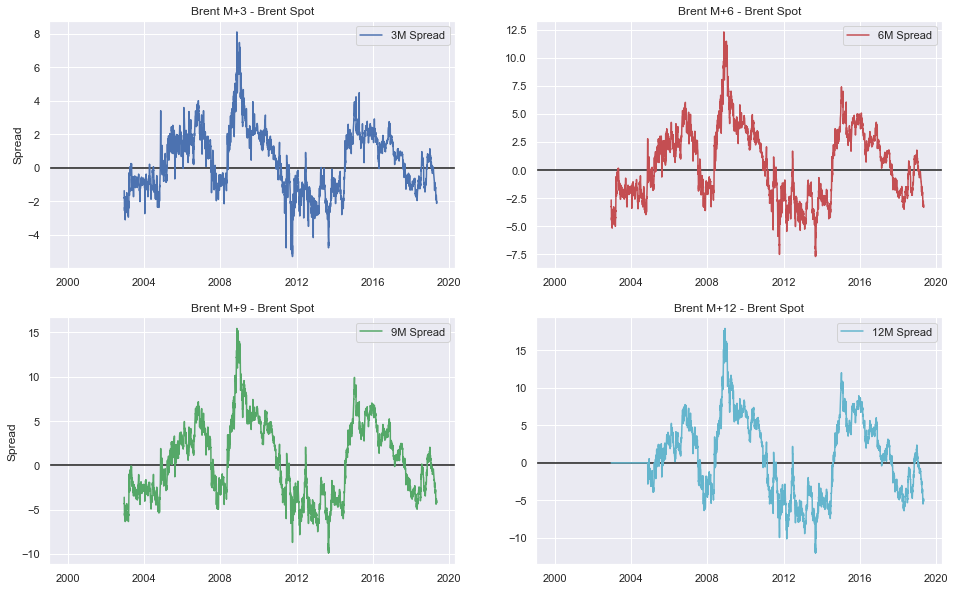

In [15]:
# Visualise each Time Spread on a 2 * 2 Grid

fig = plt.figure(figsize=(16, 10))

# 3M Spread
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=1, colspan=1)
plt.axhline(y=0, color='k')
plt.title('Brent M+3 - Brent Spot')
plt.ylabel('Spread')
ax1.plot(brent_12_months['3M Spread'], color='b', label='3M Spread')
ax1.legend()

# 6M Spread
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), rowspan=1, colspan=1)
plt.axhline(y=0, color='k')
plt.title('Brent M+6 - Brent Spot')
ax2.plot(brent_12_months['6M Spread'], color='r', label='6M Spread')
ax2.legend()

# 9M Spread
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), rowspan=1, colspan=1)
plt.axhline(y=0, color='k')
plt.title('Brent M+9 - Brent Spot')
plt.ylabel('Spread')
ax3.plot(brent_12_months['9M Spread'], color='g', label='9M Spread')
ax3.legend()

# 12M Spread
ax4 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1, colspan=1)
plt.axhline(y=0, color='k')
plt.title('Brent M+12 - Brent Spot')
ax4.plot(brent_12_months['12M Spread'], color='c', label='12M Spread')
ax4.legend();

### Analysis

A multi-plot analysis of price spreads across time reflects the same facts about the market for Brent Crude Oil - namely, that prices for Brent in various deferred months are lower than current spot prices.

Given the steep backwardation observed earlier, price spreads between the [Front Month Contract](https://www.investopedia.com/terms/f/front-month-contract.asp) and the [Back Month Contracts](https://www.investopedia.com/terms/b/backmonths.asp) increase in size as we go further out in time. (Note that the 12-month time spread is at -$\$$5.09 but the 3-month time spread is at -$2.03)

Historically, we can see that in periods of steep [contango](https://www.investopedia.com/terms/c/contango.asp) (e.g. 2008-2010), the calendar spread can be as high as $\$$15 per barrel. Periods such as these present arbitrage opportunities when traders buy the commodity at spot prices, stockpile them at a [storage facility](https://www.vopak.com/tank-terminals), and contract to sell the barrels in a few months' time - thus capturing the 'storage arb').

### 3. Geographical Spreads

In [16]:
# Query the Dubai Crude Contract on CME and its corresponding attributes
dubai_contracts = all_available_contracts[
    (all_available_contracts['Name'].str.contains('Dubai'))
]

dubai_contracts

,Ticker,Exchange,Name,Months,Number of Contracts,Quandl Code
115,DB,CME,Brent Crude Oil vs. Dubai Crude Oil (Platts),FGHJKMNQUVXZ,2,CHRIS/CME_DB
116,DC,CME,Dubai Crude Oil (Platts) Financial,HJKMNQUVXZ,2,CHRIS/CME_DC


In [17]:
# 'CHRIS/CME_DC' is the Quandl Code that we are interested in
# Query prices for Dubai Crude futures traded on the Chicago Mercantile Exchange
dubai_crude = quandl.get(f'CHRIS/CME_DC1')['Settle']

In [18]:
dubai_crude.tail()

Date
2019-05-01    70.950
2019-05-02    70.950
2019-05-03    70.637
2019-05-06    70.556
2019-05-07    69.412
Name: Settle, dtype: float64

In [19]:
# Combine Brent and Dubai Futures Time Series into a single pandas DataFrame object
brent_dubai = pd.DataFrame()
brent_dubai['Brent'] = brent_datasets['brent_1']
brent_dubai['Dubai'] = dubai_crude

In [20]:
brent_dubai.dropna(inplace=True)
brent_dubai.tail()

,Brent,Dubai
Date,,
2019-05-01,72.18,70.950
2019-05-02,70.75,70.950
2019-05-03,70.85,70.637
2019-05-06,71.24,70.556
2019-05-07,69.88,69.412


In [21]:
brent_dubai['Spread'] = brent_dubai['Brent']- brent_dubai['Dubai']

In [22]:
brent_dubai['Spread'].tail()

Date
2019-05-01    1.230
2019-05-02   -0.200
2019-05-03    0.213
2019-05-06    0.684
2019-05-07    0.468
Name: Spread, dtype: float64

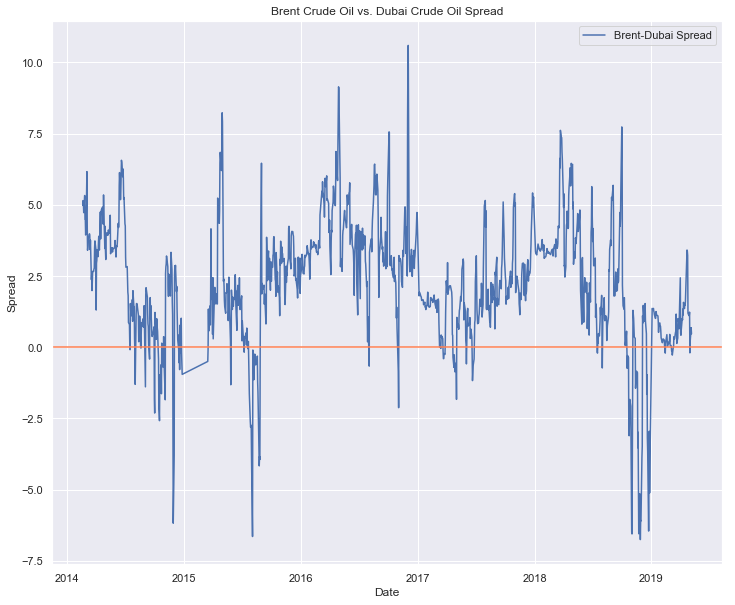

In [23]:
# Visualise the Brent-Dubai Spread
fig = plt.figure(figsize=(12, 10))
ax = sns.lineplot(x=brent_dubai.index, y="Spread", data=brent_dubai, label='Brent-Dubai Spread')
plt.title('Brent Crude Oil vs. Dubai Crude Oil Spread')
plt.axhline(y=0, color='coral');

### Analysis

Beyond time spreads, another set of opportunities in physical commodity trading are physical location spreads (i.e. buying commodities in one location and selling them at another, net of transportation costs). One example of such a spread is the [Brent-Dubai Spread](https://www.investopedia.com/articles/investing/102314/understanding-benchmark-oils-brent-blend-wti-and-dubai.asp), the difference in price between the front-month ICE Brent Futures Contract and the CME Dubai Swap.

Depending on the size of the spread, one possibly viable strategy would be to [source crude cargoes from Europe and West Africa (i.e. the Brent basket) and sell them into traditional demand centres in Asia (i.e. the Dubai basket)](https://www.hellenicshippingnews.com/analysis-key-brent-dubai-spread-sees-instability-amid-volatile-crude-prices/). As we can see from the chart above, the current spread is trading at close to $\$$0 which presents little arbitrage opportunities from a geographical perspective.

Tracking the Brent-Dubai Spread, however, may lead to the identification of future opportunities where the arbitrage becomes viable. Should the spread fall below -$\$$3, for instance, Middle Eastern crude barrels may seem expensive relative to European/West African Crude and traders can buy Brent Cargoes, ship them East of Suez, and sell them to Asian customers at a positive P&L.

### 4. Technical Spreads

In [24]:
# Filter and return the all traded Fuel Oil Contracts
fo_contracts = all_available_contracts[
    (all_available_contracts['Name'].str.contains('Fuel Oil'))
]

fo_contracts

,Ticker,Exchange,Name,Months,Number of Contracts,Quandl Code
0,0D,CME,Mini European 3.5% Fuel Oil Barges FOB Rdam (P...,FGHJKMNQUVXZ,5,CHRIS/CME_0D
1,0F,CME,Mini Singapore Fuel Oil 180 cst (Platts),HJKMNQUVXZ,2,CHRIS/CME_0F
2,1MF,SGX,Platts Singapore Fuel Oil 180cst Index,FGHJKMNQUVXZ,3,CHRIS/SGX_1MF
7,3MF,SGX,Platts Singapore Fuel Oil 380cst Index,FGHJKMNQUVXZ,2,CHRIS/SGX_3MF
63,BOB,CME,3.5% Fuel Oil Barges FOB Rdam (Platts) Crack S...,FGHJKMNQUVXZ,2,CHRIS/CME_BOB
150,EW,CME,East-West Fuel Oil Spread (Platts),FGHJKMNQUVXZ,2,CHRIS/CME_EW
157,FB,SGX,Fuel Oil 380cst,FGHJKMNQUVXZ,2,CHRIS/SGX_FB
196,FI,CME,1% Fuel Oil Cargoes FOB NWE (Platts) Crack Spread,HJKMNQUVXZ,2,CHRIS/CME_FI
224,FO,CME,3.5% Fuel Oil Barges FOB Rdam (Platts) Crack S...,FGHJKMNQUVXZ,16,CHRIS/CME_FO
230,FS,CME,1% Fuel Oil Cargoes FOB NWE (Platts) vs. 3.5% ...,FGHJKMNQUVXZ,2,CHRIS/CME_FS


In [25]:
# Query prices for continuous Singapore Fuel Oil Prices with differing grades
singapore_180 = quandl.get(f'CHRIS/CME_UA1')['Settle']
singapore_380 = quandl.get(f'CHRIS/CME_SE1')['Settle']

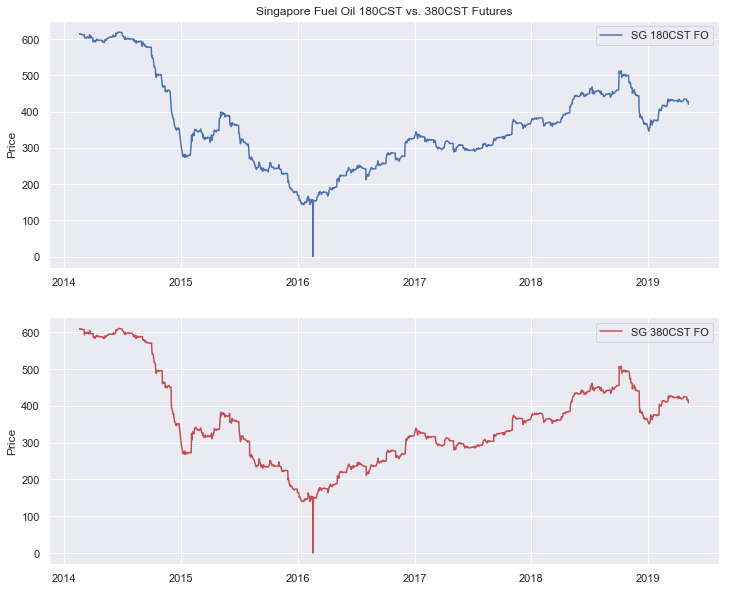

In [26]:
# Visualise both Fuel Oil price time series
singapore_180.dropna(inplace=True)
singapore_380.dropna(inplace=True)

fig = plt.figure(figsize=(12, 10))

ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1, colspan=1)
plt.title('Singapore Fuel Oil 180CST vs. 380CST Futures')
plt.ylabel('Price')

ax2 = plt.subplot2grid((2, 1), (1, 0), rowspan=1, colspan=1)
plt.ylabel('Price')

ax1.plot(singapore_180, label='SG 180CST FO')
ax2.plot(singapore_380, label='SG 380CST FO', color='r')

ax1.legend()
ax2.legend();

In [27]:
# Store the Spread Data in a pandas DataFrame
fuel_oil_spread = pd.DataFrame()
singapore_180.rename(columns={'Settle': '180CST'}, inplace=True)
singapore_380.rename(columns={'Settle': '380CST'}, inplace=True)

fuel_oil_spread['180CST'] = singapore_180
fuel_oil_spread['380CST'] = singapore_380
fuel_oil_spread['Spread'] = fuel_oil_spread['180CST'] - fuel_oil_spread['380CST']

In [28]:
fuel_oil_spread['Spread'].tail()

Date
2019-05-01     9.846
2019-05-02     6.436
2019-05-03    11.472
2019-05-06    11.553
2019-05-07    12.198
Name: Spread, dtype: float64

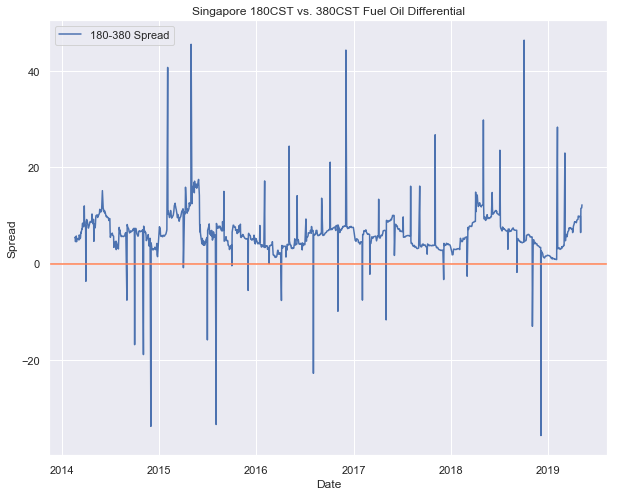

In [29]:
# Visualise the Singapore 180CST-380CST Fuel Oil Visco Spread
fig = plt.figure(figsize=(10, 8))
ax = sns.lineplot(x=fuel_oil_spread.index, y="Spread", data=fuel_oil_spread, label='180-380 Spread')
plt.title('Singapore 180CST vs. 380CST Fuel Oil Differential')
plt.axhline(y=0, color='coral');

### Analysis

A final form of physical arbitrage consists of blending and '[technical arbitrages](https://www.trafigura.com/how-physical-arbitrage-works/)'. Such strategies leverage on the fact that different markets have varying grades for commodities (such as the viscosity of Fuel Oil products).

For such strategies, one useful spread to track is the Fuel Oil Viscosity Spread (which is measured in centistokes, hence 'CST'). The chart above suggests that Singapore 180CST Fuel Oil trades at a premium to Singapore 380CST Fuel Oil, with this premium increasing in time for the year 2019.

Extremely high visco spreads generally suggest that higher-grade Fuel Oil cargoes are in greater demand to lower-grade ones. Such instances may arise in response to, for instance, [a shortage of cutter stock](https://www.hellenicshippingnews.com/asia-fuel-oil-cash-premiums-visco-spreads-jump-on-tight-cutter-supplies/) which is needed to blend 380CST Fuel Oil into bunker fuel for ships.